# Importing Libraries

In [ ]:
!pip install skforecast
!pip install session_info


In [21]:
#@ Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import session_info

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Functions

In [22]:
def rmse(y_true, y_pred ):
    se = (y_true - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


def prepare_date_format(months_request, sucursal, fechas_date_month, steps):
    months_request_analyze = months_request.loc[:,[fechas_date_month, sucursal]]
    months_request_analyze = months_request_analyze.set_index(fechas_date_month)
    months_request_analyze = months_request_analyze.rename(columns={sucursal: 'y'})
    months_request_analyze = months_request_analyze.asfreq('MS')
    months_request_analyze = months_request_analyze.sort_index()
    datos_train = months_request_analyze[:-steps]
    datos_test  = months_request_analyze[-steps:]
    #months_request_analyze.reset_index()
    return datos_train, datos_test

def prepare_date_format_exog(months_request, sucursal, fechas_date_month, steps, exog):
    months_request_analyze = months_request.loc[:,[fechas_date_month, sucursal, exog]]
    months_request_analyze = months_request_analyze.set_index(fechas_date_month)
    months_request_analyze = months_request_analyze.rename(columns={sucursal: 'y'})
    months_request_analyze = months_request_analyze.asfreq('MS')
    months_request_analyze = months_request_analyze.sort_index()
    datos_train = months_request_analyze[:-steps]
    datos_test  = months_request_analyze[-steps:]
    #months_request_analyze.reset_index()
    return datos_train, datos_test


def scaler_months(months_request,col ):
    values = months_request[col].values
    values = values.reshape((len(values), 1))
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    return scaler, normalized

#@ Prueba Fuller
def test_Dickey_Fuller(series , column_name):
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','observed number'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#@ Create variable exogen
def create_exogen_variable(date_data):
    # date_data = df.fechas_date_month
    if (date_data < pd.to_datetime('2020-03-01')):
        return 0
    elif(date_data >=  pd.to_datetime( '2020-03-01')) and (date_data <=  pd.to_datetime('2020-08-01') ):
        return 1
    else:
        return 0.80


# Data Preparation

In [23]:
data_download = 'https://raw.githubusercontent.com/AEBU/mlzoomcamp/main/capstone-project2/data/appraisal_data.csv'
data_output = 'appraisal_data.csv'

In [24]:
!wget $data_download
!head $data_output


--2023-01-27 02:25:44--  https://raw.githubusercontent.com/AEBU/mlzoomcamp/main/capstone-project2/data/appraisal_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 995 [text/plain]
Saving to: ‘appraisal_data.csv.1’

appraisal_data.csv. 100%[===================>]     995  --.-KB/s    in 0s      

2023-01-27 02:25:44 (77.6 MB/s) - ‘appraisal_data.csv.1’ saved [995/995]

,fechas_date_month,appraisal
0,2017-07-01,1.0
1,2017-08-01,0.0
2,2017-09-01,6.0
3,2017-10-01,16.0
4,2017-11-01,7.0
5,2017-12-01,5.0
6,2018-01-01,4.0
7,2018-02-01,2.0
8,2018-03-01,31.0


In [25]:
#@ Import dataset
request_equipments = pd.read_csv(data_output)

In [26]:
request_equipments.head()

,Unnamed: 0,fechas_date_month,appraisal
0,0,2017-07-01,1.0
1,1,2017-08-01,0.0
2,2,2017-09-01,6.0
3,3,2017-10-01,16.0
4,4,2017-11-01,7.0


In [27]:
request_equipments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         51 non-null     int64  
 1   fechas_date_month  51 non-null     object 
 2   appraisal          51 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


In [28]:
len(request_equipments)

51

In [29]:
request_equipments.isnull().sum()

Unnamed: 0           0
fechas_date_month    0
appraisal            0
dtype: int64

In [30]:
#@ FILTER ONLY NECCESARY FEATURES
request_appr = request_equipments[['appraisal','fechas_date_month']]
request_appr.head().T

,0,1,2,3,4
appraisal,1.0,0.0,6.0,16.0,7.0
fechas_date_month,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01


# Data Cleaning


## Change variables types

In [31]:
request_appr['fechas_date_month'] = pd.to_datetime(request_appr['fechas_date_month'], format='%Y-%m-%d')
(request_appr['fechas_date_month'].min(), request_appr['fechas_date_month'].max())

<ipython-input-31-294c159e1179>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_appr['fechas_date_month'] = pd.to_datetime(request_appr['fechas_date_month'], format='%Y-%m-%d')


(Timestamp('2017-07-01 00:00:00'), Timestamp('2021-09-01 00:00:00'))

## Analysis Target Variable

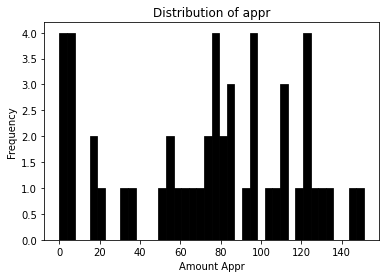

In [32]:
plt.figure(figsize=(6, 4))

sns.histplot(request_appr.appraisal, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Amount Appr')
plt.title('Distribution of appr')

plt.show()

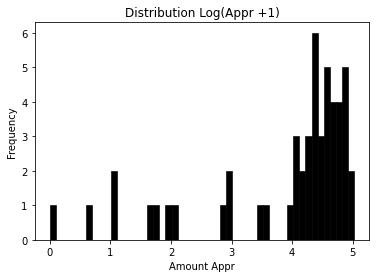

In [33]:
log_price = np.log1p(request_appr.appraisal)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=50, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Amount Appr')
plt.title('Distribution Log(Appr +1)')
plt.show()

In [34]:
fig = px.line(request_appr, x='fechas_date_month', y="appraisal")
fig.show()

# EDA

## Features Analysis

In [35]:
request_appr.head()

,appraisal,fechas_date_month
0,1.0,2017-07-01
1,0.0,2017-08-01
2,6.0,2017-09-01
3,16.0,2017-10-01
4,7.0,2017-11-01


In [36]:
#@ Predominant appr
request_appr.appraisal.value_counts().head(10)

124.0    2
96.0     2
77.0     2
84.0     2
2.0      2
121.0    2
111.0    2
80.0     1
91.0     1
56.0     1
Name: appraisal, dtype: int64

In [37]:
#@ Create exogen variable with perception of covid 
request_appr['exog_1'] = request_appr.fechas_date_month.apply(create_exogen_variable)

In [38]:
fig = px.line(request_appr, x='fechas_date_month', y="appraisal")
# fig = px.line(request_appr, x='fechas_date_month', y="exog_1")
fig.show()

## Split Train-Test

In [39]:
data_train, data_test  = prepare_date_format(request_appr, 'appraisal', 'fechas_date_month', 12)

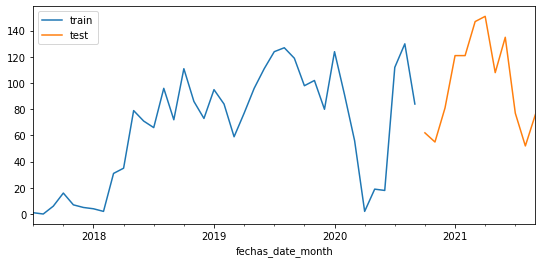

In [40]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

# Model Selection

## ForecasterAutoreg

In [41]:
steps = 12 


In [42]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 12
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-07-01 00:00:00'), Timestamp('2020-09-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 02:25:46 
Last fit date: 2023-01-27 02:25:47 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [43]:
# Predictions
# ==============================================================================
predicts = forecaster.predict(steps=steps)
predicts.head(5)

2020-10-01    53.51
2020-11-01    84.82
2020-12-01    98.45
2021-01-01    96.42
2021-02-01    94.83
Freq: MS, Name: pred, dtype: float64

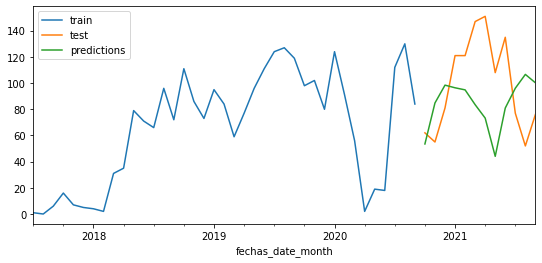

In [44]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predicts.plot(ax=ax, label='predictions')
ax.legend();

In [45]:
# Error test
# ==============================================================================
error_rmse = rmse(data_test['y'],predicts)
# error_mse = mean_squared_error(
#                 y_true = 
#                 y_pred = predicts
#             )
print(f"Error de test (mse): {error_rmse}")

Error de test (mse): 44.32395110622097


## Tunning

### Model Normal


In [46]:
metrics = ['mean_absolute_error', mean_squared_error, rmse]


In [47]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = metrics,
                        initial_train_size = int(len(data_train)*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:17<00:00,  8.69s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 39.818333333333335



In [48]:
lags_forecaster = 20
max_depth = 3
n_estaimators = 500
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estaimators, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = lags_forecaster
             )

forecaster.fit(y=data_train['y'])

In [49]:
prediction_tunning = forecaster.predict(steps=steps)


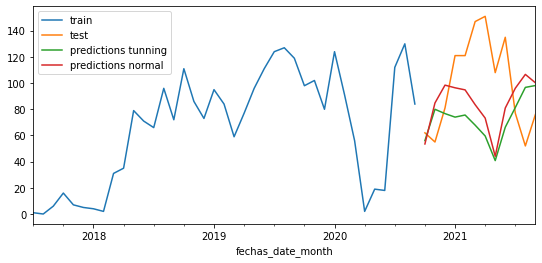

In [50]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
prediction_tunning.plot(ax=ax, label='predictions tunning')
predicts.plot(ax=ax, label='predictions normal')
ax.legend();

In [51]:
# Error test
# ==============================================================================
error_rmse = rmse(data_test['y'],prediction_tunning)
# error_mse = mean_squared_error(
#                 y_true = 
#                 y_pred = predicts
#             )
print(f"Error de test (mse): {error_rmse}")

Error de test (mse): 51.07395001981491


### Backtesting

In [52]:
# Backtesting
# ==============================================================================
steps = 12
n_backtesting = 12*2

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = request_appr['appraisal'],
                                    initial_train_size = len(request_appr) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = ['mean_squared_error', rmse],
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 27
Number of observations used for backtesting: 24
    Number of folds: 2
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   0 -- 26  (n=27)
    Validation: 27 -- 38  (n=12)
Data partition in fold: 1
    Training:   0 -- 38  (n=39)
    Validation: 39 -- 50  (n=12)

Error de backtest: [2795.830470054016, 52.875613188444596]


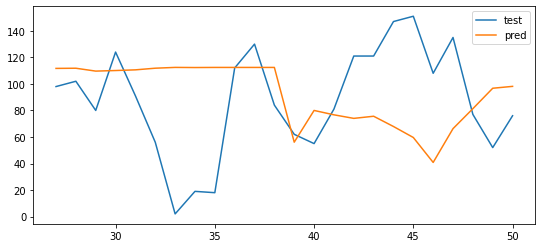

In [53]:
fig, ax = plt.subplots(figsize=(9, 4))
request_appr.loc[predicciones_backtest.index, 'appraisal'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();


In [54]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.091702
1,lag_2,0.012130
2,lag_3,0.010827
3,lag_4,0.008001
4,lag_5,0.018684
5,lag_6,0.009308
6,lag_7,0.011254
7,lag_8,0.062111
8,lag_9,0.395740
9,lag_10,0.055385


### Exogen Variables

In [55]:
data_train, data_test  = prepare_date_format_exog(request_appr, 'appraisal', 'fechas_date_month', 12, 'exog_1')

# def prepare_date_format(months_request, sucursal, fechas_date_month, steps):


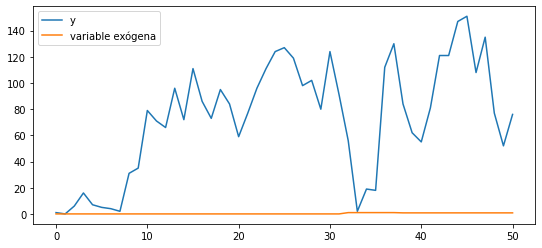

In [56]:
fig, ax = plt.subplots(figsize=(9, 4))
request_appr['appraisal'].plot(ax=ax, label='y')
request_appr['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [57]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('2017-07-01 00:00:00'), Timestamp('2020-09-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 02:26:25 
Last fit date: 2023-01-27 02:26:25 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [58]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('2017-07-01 00:00:00'), Timestamp('2020-09-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 02:26:25 
Last fit date: 2023-01-27 02:26:26 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [59]:
# Predicciones
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

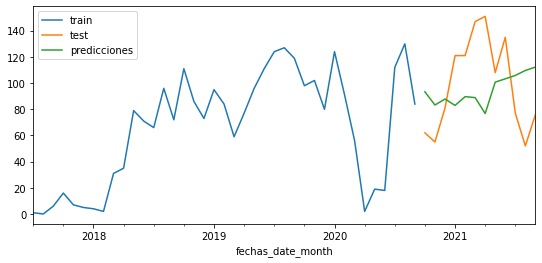

In [60]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [61]:
rmse(data_test['y'], predictions )

40.49076520228615

In [62]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        exog               = data_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = rmse,
                        initial_train_size = int(len(data_train)*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:18<00:00,  6.06s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 49.83673617323793



### Forecaster Standar

In [63]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = steps,
                lags          = 6 # Este valor será remplazado en el grid search
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = steps,
                    refit              = True,
                    metric             = rmse,
                    initial_train_size = int(len(data_train)*0.9),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 30.


loop param_grid:   0%|                                             | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-03, tolerance: 1.741e-04

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-03, tolerance: 2.201e-04

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-03, tolerance: 

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 39.5106789362066



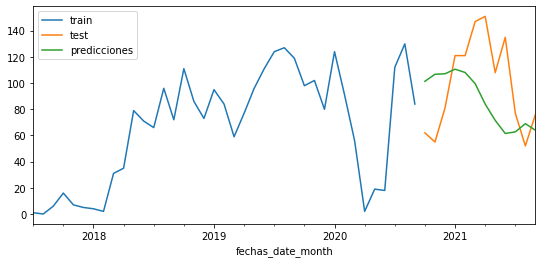

In [64]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [65]:
output_file = f'model_appr.bin'

In [66]:
f_out = open(output_file, 'wb') 
pickle.dump(forecaster, f_out)
f_out.close()

In [67]:
# Open the file with Vectorizer
with open(output_file, 'rb') as f_in:
    model_forecaster = pickle.load(f_in)
f_in.close()

In [68]:
model_forecaster.predict(12)

2020-10-01    101.375
2020-11-01    106.750
2020-12-01    107.125
2021-01-01    110.625
2021-02-01    108.125
2021-03-01     99.625
2021-04-01     84.000
2021-05-01     71.500
2021-06-01     61.500
2021-07-01     62.750
2021-08-01     69.000
2021-09-01     64.000
Name: pred, dtype: float64

In [71]:
session_info.show(html=False)

-----
matplotlib          3.2.2
numpy               1.21.6
pandas              1.3.5
plotly              5.5.0
seaborn             0.11.2
session_info        1.0.0
skforecast          0.6.0
sklearn             1.0.2
statsmodels         0.12.2
-----
IPython             7.9.0
jupyter_client      6.1.12
jupyter_core        5.1.3
notebook            5.7.16
-----
Python 3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29
-----
Session information updated at 2023-01-27 02:27
